Analysis of the range of television station transmitters. Calculation of the station density in h3 hexagon fields.

In [3]:
from sedona.spark import *
from pyspark.sql.functions import concat_ws, col, expr, udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import explode
from shapely import wkt
import geopandas as gpd
import matplotlib.pyplot as plt
from sedona.maps.SedonaKepler import SedonaKepler
from keplergl import KeplerGl
import pydeck as pdk

In [4]:
config = SedonaContext.builder().appName('fcc')\
    .config("spark.hadoop.fs.s3a.bucket.wherobots-geodata.aws.credentials.provider","org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider")\
    .getOrCreate()
sedona = SedonaContext.create(config)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


The source data contains information about TV stations and has 360 coordinates of transmitter range. The geometry of polygons should be created from these 360 coordinates.

In [5]:
S3_URL_TV = "s3://wherobots-geodata/TV_service_contour_current.txt"

In [6]:
tv_df = sedona.read.format('csv').option('header', 'true').option('delimiter', '|').load(S3_URL_TV)

In [7]:
tv_df.count()

8528

In [ ]:
tv_df.printSchema()

In [8]:
type(tv_df)

pyspark.sql.dataframe.DataFrame

For better map readability, the number of station transmitters has been reduced to 1000.

In [80]:
tv_df_1000 = tv_df.limit(1000)

In [81]:
desc_cols = tv_df_1000.columns[:5]
coord_cols = tv_df_1000.columns[5: 366]

In [82]:
def row_to_wkt(row):
    coords = []
    for point in row:
        lat, lon = map(float, point.split(','))
        coords.append(f"{lon} {lat}")  
    return f"POLYGON (({', '.join(coords)}))"

to_wkt_udf = udf(row_to_wkt, StringType())

desc_cols = tv_df_1000.columns[:5]
coord_cols = tv_df_1000.columns[5:365]

df_with_wkt = tv_df_1000.withColumn("wkt_geometry", to_wkt_udf(array(*[col(c) for c in coord_cols])))
df_geom = df_with_wkt.withColumn("geometry", ST_GeomFromWKT("wkt_geometry"))


final_df = df_geom.select(*desc_cols, "geometry")

In [83]:
final_df.show()

+--------------+-------+--------------------+---------------+--------------------+--------------------+
|application_id|service|  lms_application_id|dts_site_number|    transmitter_site|            geometry|
+--------------+-------+--------------------+---------------+--------------------+--------------------+
|    2036528   |    LPD|25076ff3729b1e0a0...|             01|59.97375 ,-154.84911|POLYGON ((-154.84...|
|    2020763   |    DTV|25076f9169e0309d0...|             01|35.00250 ,-87.13583 |POLYGON ((-87.135...|
|    2051473   |    LPD|25076ff386f28a460...|             01|33.05058 ,-114.82803|POLYGON ((-114.82...|
|    2047477   |    LPD|25076ff380754a570...|             01|33.05058 ,-114.82803|POLYGON ((-114.82...|
|    2047332   |    LPD|25076ff38197b72e0...|             01|37.21722 ,-120.20000|POLYGON ((-120.2 ...|
|    2045786   |    LPD|25076ff3818b1da20...|             01|33.87083 ,-116.22778|POLYGON ((-116.22...|
|    2042394   |    LPD|25076ff379edbd630...|             01|33.

In [84]:
final_df.printSchema()

root
 |-- application_id: string (nullable = true)
 |-- service: string (nullable = true)
 |-- lms_application_id: string (nullable = true)
 |-- dts_site_number: string (nullable = true)
 |-- transmitter_site: string (nullable = true)
 |-- geometry: geometry (nullable = true)



In [85]:
final_df.cache()

25/05/05 13:39:52 WARN CacheManager: Asked to cache already cached data.


DataFrame[application_id: string, service: string, lms_application_id: string, dts_site_number: string, transmitter_site: string, geometry: udt]

In [48]:
final_df.createOrReplaceTempView("tv")

In [17]:
SedonaKepler.create_map(final_df, "Transmitter range")

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Transmitter range': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1…

In [18]:
final_df.count()

1000

Creation a hexagonal grid layer (H3) that counts how many transmitters are in each hexagon.

ST_H3CellIDs(geometry, 2, false) For each object (e.g. point, polygon), it lists H3 cells on level 2 that the geometry intersects.
ST_H3ToGeom(...) Converts H3 cells to their geometric representation (Polygon) — that is, from H3 ID → to polygon.
COUNT(*) AS num Counts how many geometries are assigned to each H3.
GROUP BY h3 Groups by H3 hexagons — counts one row per H3 cell with the number of objects that belong to it.

In [19]:
hexagons = sedona.sql("""
SELECT COUNT(*) AS num, ST_H3ToGeom(ST_H3CellIDs(geometry, 2, false)) as geometry, ST_H3CellIDs(geometry, 2, false) as h3 
FROM tv 
GROUP BY h3
""")

In [21]:
hexagons.show()

+---+--------------------+--------------------+
|num|            geometry|                  h3|
+---+--------------------+--------------------+
| 10|[POLYGON ((-73.64...|[586223865802260479]|
|  9|[POLYGON ((-80.65...|[586216718976679935]|
|  4|[POLYGON ((-74.44...|[586218917999935487]|
| 12|[POLYGON ((-119.2...|[586186482406916095]|
| 12|[POLYGON ((-119.2...|[586181534604591103]|
| 15|[POLYGON ((-123.2...|[586188681430171647]|
| 12|[POLYGON ((-119.7...|[585800004069752831]|
|  8|[POLYGON ((-93.41...|[586160094127849471]|
| 13|[POLYGON ((-89.57...|[586160643883663359]|
|  7|[POLYGON ((-89.24...|[586158994616221695]|
|  6|[POLYGON ((-103.5...|[586147999499943935]|
| 12|[POLYGON ((-106.7...|[586145800476688383]|
| 12|[POLYGON ((-109.7...|[586165041930174463]|
|  4|[POLYGON ((-104.1...|[586163942418546687]|
| 10|[POLYGON ((-84.76...|[586680712883601407]|
| 11|[POLYGON ((-96.86...|[586152947302268927]|
|  9|[POLYGON ((-93.26...|[586669717767323647]|
| 11|[POLYGON ((-89.74...|[5861430516976

In [22]:
hexagons.printSchema()

root
 |-- num: long (nullable = false)
 |-- geometry: array (nullable = true)
 |    |-- element: geometry (containsNull = true)
 |-- h3: array (nullable = true)
 |    |-- element: long (containsNull = true)



The code is used to "flatten" the geometry column, which is an array of geometries, into a single geometry.
Now each value in the geometry column is a single geometry object, not a list. This makes it easier to:

visualize (e.g. in Pydeck, Kepler, Folium)

export to GeoDataFrame

further spatial calculations

In [23]:
data_with_geometry = hexagons.withColumn("geometry", hexagons["geometry"][0])

In [24]:
data_with_geometry.printSchema()

root
 |-- num: long (nullable = false)
 |-- geometry: geometry (nullable = true)
 |-- h3: array (nullable = true)
 |    |-- element: long (containsNull = true)



In [25]:
data_with_geometry.show()

+---+--------------------+--------------------+
|num|            geometry|                  h3|
+---+--------------------+--------------------+
| 10|POLYGON ((-73.646...|[586223865802260479]|
|  9|POLYGON ((-80.651...|[586216718976679935]|
|  4|POLYGON ((-74.442...|[586218917999935487]|
| 12|POLYGON ((-119.23...|[586186482406916095]|
| 12|POLYGON ((-119.23...|[586181534604591103]|
| 15|POLYGON ((-123.21...|[586188681430171647]|
| 12|POLYGON ((-119.74...|[585800004069752831]|
|  8|POLYGON ((-93.418...|[586160094127849471]|
| 13|POLYGON ((-89.578...|[586160643883663359]|
|  7|POLYGON ((-89.249...|[586158994616221695]|
|  6|POLYGON ((-103.53...|[586147999499943935]|
| 12|POLYGON ((-106.73...|[586145800476688383]|
| 12|POLYGON ((-109.78...|[586165041930174463]|
|  4|POLYGON ((-104.14...|[586163942418546687]|
| 10|POLYGON ((-84.761...|[586680712883601407]|
| 11|POLYGON ((-96.863...|[586152947302268927]|
|  9|POLYGON ((-93.265...|[586669717767323647]|
| 11|POLYGON ((-89.748...|[5861430516976

In [26]:
SedonaKepler.create_map(data_with_geometry, "heksagons")

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'heksagons': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2…

In [28]:
mapa = KeplerGl()

SedonaKepler.add_df(mapa, final_df, name="transmiter range")

SedonaKepler.add_df(mapa, data_with_geometry, name="heksagony")

mapa

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'transmiter range': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18…

In [29]:
data_with_geometry.show()

+---+--------------------+--------------------+
|num|            geometry|                  h3|
+---+--------------------+--------------------+
| 10|POLYGON ((-73.646...|[586223865802260479]|
|  9|POLYGON ((-80.651...|[586216718976679935]|
|  4|POLYGON ((-74.442...|[586218917999935487]|
| 12|POLYGON ((-119.23...|[586186482406916095]|
| 12|POLYGON ((-119.23...|[586181534604591103]|
| 15|POLYGON ((-123.21...|[586188681430171647]|
| 12|POLYGON ((-119.74...|[585800004069752831]|
|  8|POLYGON ((-93.418...|[586160094127849471]|
| 13|POLYGON ((-89.578...|[586160643883663359]|
|  7|POLYGON ((-89.249...|[586158994616221695]|
|  6|POLYGON ((-103.53...|[586147999499943935]|
| 12|POLYGON ((-106.73...|[586145800476688383]|
| 12|POLYGON ((-109.78...|[586165041930174463]|
|  4|POLYGON ((-104.14...|[586163942418546687]|
| 10|POLYGON ((-84.761...|[586680712883601407]|
| 11|POLYGON ((-96.863...|[586152947302268927]|
|  9|POLYGON ((-93.265...|[586669717767323647]|
| 11|POLYGON ((-89.748...|[5861430516976

In [30]:
pdf = data_with_geometry.toPandas()

In [31]:
gdf = gpd.GeoDataFrame(pdf, geometry="geometry")

gdf["coordinates"] = gdf["geometry"].apply(lambda geom: [list(geom.exterior.coords)])

In [32]:
polygon_layer = pdk.Layer(
    "PolygonLayer",
    data=gdf,
    get_polygon="coordinates",
    get_fill_color="[num * 50, 100, 150, 180]",  
    pickable=True,
    stroked=True,
    auto_highlight=True,
)

view_state = pdk.ViewState(
    latitude=gdf.geometry.centroid.y.mean(),
    longitude=gdf.geometry.centroid.x.mean(),
    zoom=5,
    pitch=0,
)

deck = pdk.Deck(
    layers=[polygon_layer],
    initial_view_state=view_state,
    tooltip={"text": "num: {num}"}
)

deck.show()

In [86]:
hexagons2 = final_df.select(explode(expr("ST_H3CellIDs(geometry, 2, false)")).alias("h3"))

In [87]:
agg_df = hexagons2.groupBy("h3").count().withColumnRenamed("count", "num")

In [88]:
final_df = agg_df.withColumn("geometry", expr("ST_H3ToGeom(array(h3))"))

In [89]:
df_pd = final_df.toPandas()

In [90]:
print(type(df_pd['geometry'].iloc[0]))
print(df_pd['geometry'].iloc[0])

<class 'list'>
[<POLYGON ((-155.277 59.198, -152.643 58.589, -149.957 59.398, -149.734 60.88...>]


In [91]:
df_pd['geometry'] = df_pd['geometry'].apply(lambda x: x[0])

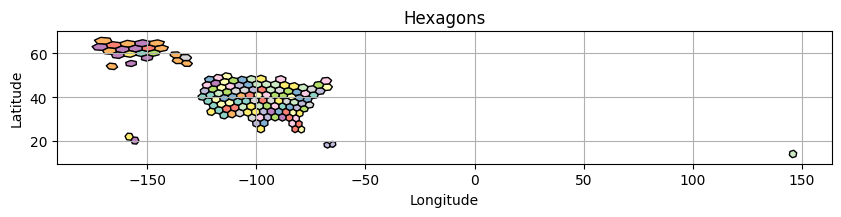

In [94]:
gdf = gpd.GeoDataFrame(df_pd, geometry='geometry')

gdf.plot(edgecolor='black', cmap='Set3', figsize=(10, 8))
plt.title("Hexagons")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

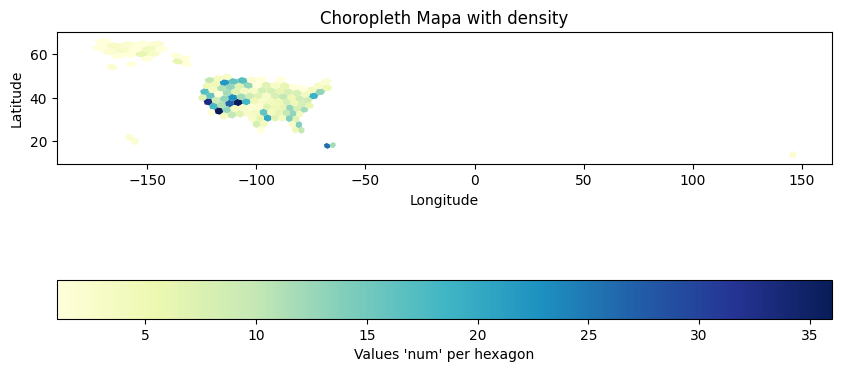

In [95]:
fig, ax = plt.subplots(figsize=(10, 10))


gdf.plot(column='num', ax=ax, legend=True,
         legend_kwds={'label': "Values 'num' per hexagon",
                      'orientation': "horizontal"},
         cmap='YlGnBu') 

# Ustawienia mapy
ax.set_title("Choropleth Mapa with density")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Wyświetl mapę
plt.show()